# Step 1.1) Load Libraries¶
Import all necessary libraries for the project.

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import re  
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingRegressor


# Step 1.2) Load the dataset
Load the dataset and display the first few rows.

In [2]:
df = pd.read_csv("housing.csv")
df.head()
#df.shape

,Avg. Area Income,Avg. Area House Age,Avg. Area Number of Rooms,Avg. Area Number of Bedrooms,Area Population,Price,Address
0,79545.45857,5.682861,7.009188,4.09,23086.80050,1.059034e+06,"208 Michael Ferry Apt. 674\nLaurabury, NE 3701..."
1,79248.64245,6.002900,6.730821,3.09,40173.07217,1.505891e+06,"188 Johnson Views Suite 079\nLake Kathleen, CA..."
2,61287.06718,5.865890,8.512727,5.13,36882.15940,1.058988e+06,"9127 Elizabeth Stravenue\nDanieltown, WI 06482..."
3,63345.24005,7.188236,5.586729,3.26,34310.24283,1.260617e+06,USS Barnett\nFPO AP 44820
4,59982.19723,5.040555,7.839388,4.23,26354.10947,6.309435e+05,USNS Raymond\nFPO AE 09386


In [3]:
# Step 1: Parse the Address Column
# Your addresses are multi-line strings. We'll break them into: Street,City,State,ZIP Code
# Function to parse city, state, and ZIP from the second line of address
def parse_address(addr):
    # Extract the second line (usually contains city, state ZIP)
    lines = addr.split('\n')
    if len(lines) < 2:
        return pd.Series([None, None, None])
    
    line2 = lines[1]
    
    # Try extracting with regex
    match = re.search(r'(?P<city>.+),\s+(?P<state>[A-Z]{2})\s+(?P<zip>\d{5})', line2)
    if match:
        return pd.Series([match.group('city'), match.group('state'), match.group('zip')])
    else:
        return pd.Series([None, None, None])

df[['City', 'State', 'ZipCode']] = df['Address'].apply(parse_address)
#Step 2: Encode the Categorical Features
#Once extracted City, State, and ZipCode, convert them for modeling:

# Encode State and City
le_state = LabelEncoder()
df['State_encoded'] = le_state.fit_transform(df['State'].astype(str))

le_city = LabelEncoder()
df['City_encoded'] = le_city.fit_transform(df['City'].astype(str))

# Optionally convert ZipCode to numeric or categorical:
df['ZipCode'] = df['ZipCode'].astype(str)
df['Zip3'] = df['ZipCode'].str[:3]  # First 3 digits (area code style)
df['Zip3_encoded'] = LabelEncoder().fit_transform(df['Zip3'])


# Step 2.1) Descriptive Statistics
Generate summary statistics for the dataset.

In [34]:
summary = df.describe()
print(summary)
print(df.dtypes)


       Avg. Area Income  Avg. Area House Age  Avg. Area Number of Rooms  \
count       5200.000000          5200.000000                5200.000000   
mean       68572.970739             5.978627                   6.985473   
std        10590.082506             0.987069                   1.000218   
min        39965.806605             3.301605                   4.303896   
25%        61466.186425             5.323276                   6.299692   
50%        68785.529025             5.976211                   7.002245   
75%        75769.457190             6.655164                   7.661949   
max        96753.820000             8.705802                   9.657013   

       Avg. Area Number of Bedrooms  Area Population         Price  \
count                   5200.000000      5200.000000  5.200000e+03   
mean                       3.977373     36129.573564  1.231256e+06   
std                        1.231469      9824.378120  3.508509e+05   
min                        2.000000      940

# Step 2.2) Data Visualizations
Visualize the data to identify patterns and relationships.

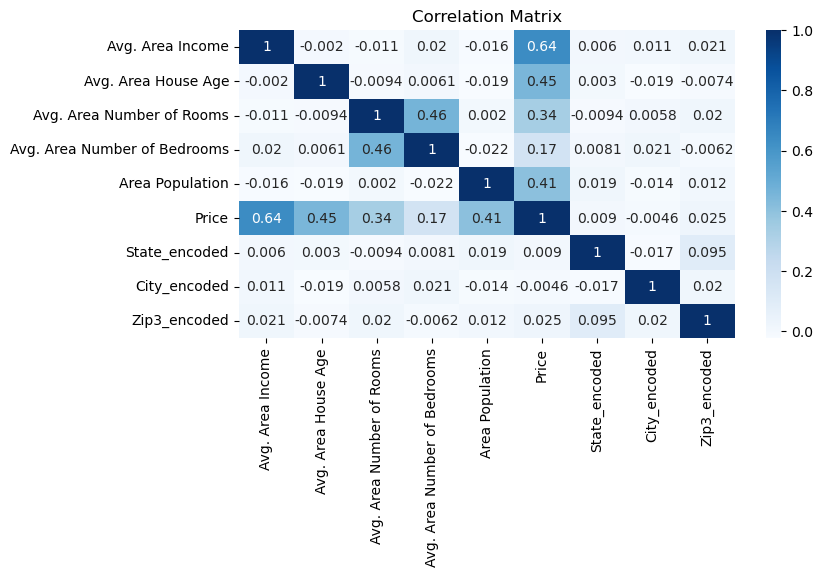

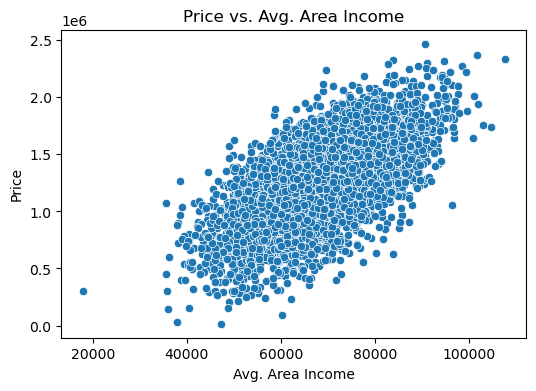

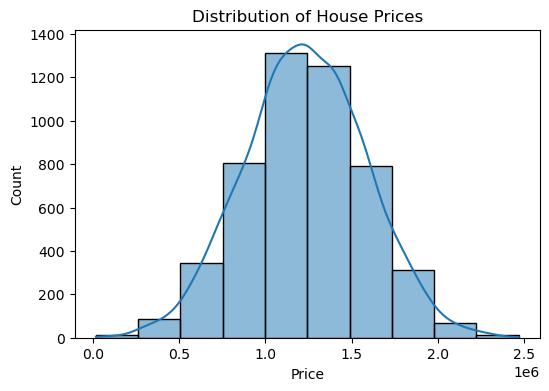

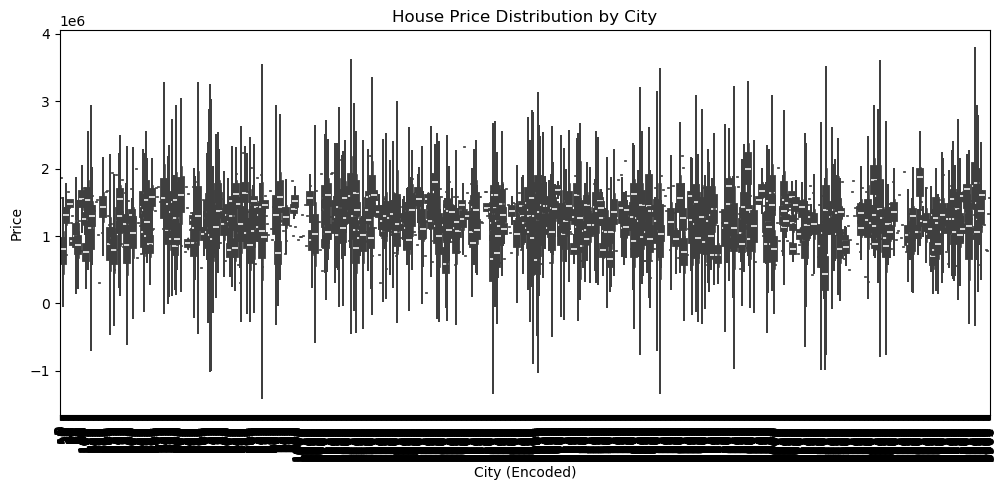

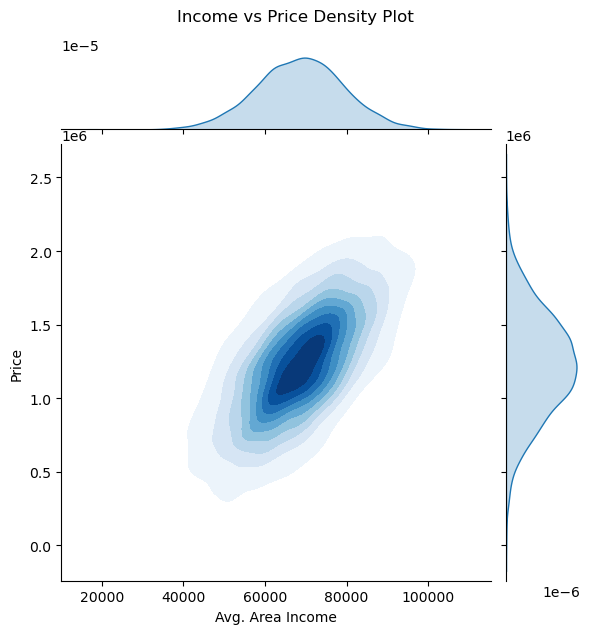

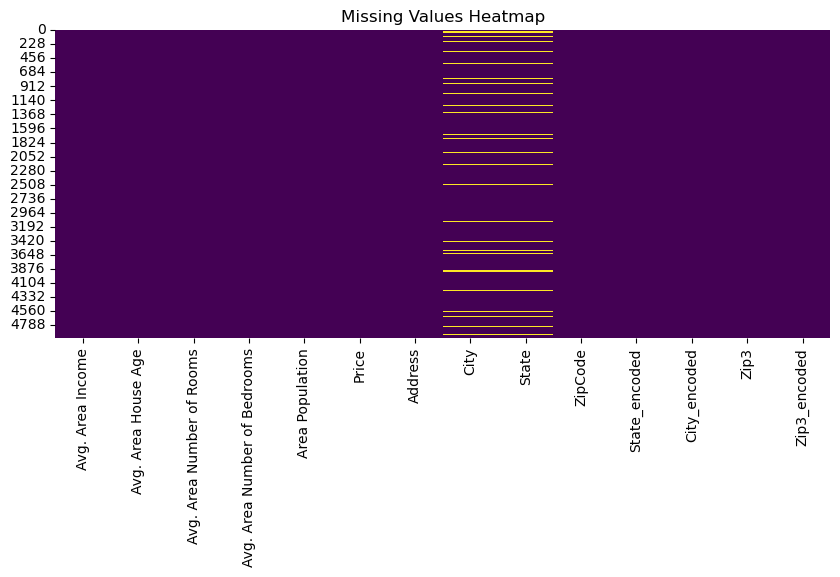

In [4]:

df_numeric = df[[
    'Avg. Area Income',
    'Avg. Area House Age',
    'Avg. Area Number of Rooms',
    'Avg. Area Number of Bedrooms',
    'Area Population',
    'Price',
    'State_encoded',     
    'City_encoded',        
    'Zip3_encoded'          
]]

# Heatmap - 
plt.figure(figsize=(8, 4))
sns.heatmap(df_numeric.corr(), annot=True, cmap='Blues')
plt.title("Correlation Matrix")
plt.show()

# Scatterplot
plt.figure(figsize=(6, 4))
sns.scatterplot(x='Avg. Area Income', y='Price', data=df_numeric)
plt.title("Price vs. Avg. Area Income")
plt.show()

# Histogram
plt.figure(figsize=(6, 4))
sns.histplot(df_numeric['Price'], bins=10, kde=True)
plt.title("Distribution of House Prices")
plt.show()

#Shows scatter + distribution + density contours:

sns.jointplot(x='Avg. Area Income', y='Price', data=df_numeric, kind='kde', fill=True, cmap='Blues')
plt.suptitle("Income vs Price Density Plot", y=1.05)
plt.show()
# If your dataset has missing values, visualize them:
plt.figure(figsize=(10, 4))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()




# Step 3.1 Clean Data
 Handle Missing Value

In [106]:
df.isnull().sum()


Avg. Area Income                  0
Avg. Area House Age               0
Avg. Area Number of Rooms         0
Avg. Area Number of Bedrooms      0
Area Population                   0
Price                             0
Address                           0
City                            514
State                           514
ZipCode                           0
State_encoded                     0
City_encoded                      0
Zip3                              0
Zip3_encoded                      0
dtype: int64

In [111]:
#Best Idea: Use ZipCode to Fill Missing City and State

#Since each ZipCode is generally tied to a unique City and State, I can use ZipCode to look up the missing values.

In [5]:
# Create reference from non-null rows
zip_to_city_state = df[df['City'].notnull()][['ZipCode', 'City', 'State']].drop_duplicates()
# Merge to fill missing city/state
df = df.merge(zip_to_city_state, on='ZipCode', how='left', suffixes=('', '_ref'))

# Fill only where original is null
df['City'] = df['City'].fillna(df['City_ref'])
df['State'] = df['State'].fillna(df['State_ref'])

# Drop the temporary columns
df.drop(['City_ref', 'State_ref'], axis=1, inplace=True)
#If some ZipCodes don’t help recover City/State, use mode imputation:

df['City'] = df['City'].fillna(df['City'].mode()[0])
df['State'] = df['State'].fillna(df['State'].mode()[0])


In [113]:
df.isnull().sum()


Avg. Area Income                0
Avg. Area House Age             0
Avg. Area Number of Rooms       0
Avg. Area Number of Bedrooms    0
Area Population                 0
Price                           0
Address                         0
City                            0
State                           0
ZipCode                         0
State_encoded                   0
City_encoded                    0
Zip3                            0
Zip3_encoded                    0
dtype: int64

# Handle Outliers

In [6]:

df_numeric = df.select_dtypes(include=['int64', 'float64']).columns

outlier_summary = {}

for col in df_numeric:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outlier_count = outliers.shape[0]

    outlier_summary[col] = {
        'Outlier Count': outlier_count,
        'Lower Bound': lower_bound,
        'Upper Bound': upper_bound
    }

outlier_df = pd.DataFrame(outlier_summary).T.sort_values(by='Outlier Count', ascending=False)
print(outlier_df)


                              Outlier Count    Lower Bound   Upper Bound
Price                                  42.0  288989.511625  2.177657e+06
Avg. Area Income                       33.0   40011.280278  9.722436e+04
Area Population                        31.0    9278.393004  6.294380e+04
Avg. Area Number of Rooms              28.0       4.256306  9.705335e+00
Avg. Area House Age                    26.0       3.325443  8.652996e+00
Avg. Area Number of Bedrooms            0.0       1.115000  6.515000e+00
State_encoded                           0.0     -27.000000  8.500000e+01
City_encoded                            0.0   -1439.375000  5.377625e+03
Zip3_encoded                            0.0    -523.500000  1.624500e+03


In [8]:
# Recommended Strategy: Capping (Clipping) Outliers
#This keeps the rows but replaces outliers with the nearest valid values. It’s a balanced and safe approach.


In [10]:
# Define the bounds based data
outlier_bounds = {
    'Price': (301832.2915, 2153333.0),
    'Avg. Area Number of Rooms': (4.303896, 9.657013),
    'Avg. Area Income': (39965.806605, 96753.82),
    'Area Population': (9409.21192, 62785.73),
    'Avg. Area House Age': (3.301605, 8.705802),
    'Avg. Area Number of Bedrooms': (1.13, 6.49)
}

# Apply clipping
for col, (lower, upper) in outlier_bounds.items():
    df[col] = df[col].clip(lower, upper)


# Step 3.1) Feature Selection¶
Select the most relevant features for the model.

In [117]:
df.head()

,Avg. Area Income,Avg. Area House Age,Avg. Area Number of Rooms,Avg. Area Number of Bedrooms,Area Population,Price,Address,City,State,ZipCode,State_encoded,City_encoded,Zip3,Zip3_encoded
0,79545.45857,5.682861,7.009188,4.09,23086.80050,1059033.558,"208 Michael Ferry Apt. 674\nLaurabury, NE 3701...",Laurabury,NE,37010,34,1607,370,367
1,79248.64245,6.002900,6.730821,3.09,40173.07217,1505890.915,"188 Johnson Views Suite 079\nLake Kathleen, CA...",Lake Kathleen,CA,48958,5,1473,489,484
2,79248.64245,6.002900,6.730821,3.09,40173.07217,1505890.915,"188 Johnson Views Suite 079\nLake Kathleen, CA...",Lake Kathleen,CA,48958,5,1473,489,484
3,79248.64245,6.002900,6.730821,3.09,40173.07217,1505890.915,"188 Johnson Views Suite 079\nLake Kathleen, CA...",Lake Kathleen,CA,48958,5,1473,489,484
4,79248.64245,6.002900,6.730821,3.09,40173.07217,1505890.915,"188 Johnson Views Suite 079\nLake Kathleen, CA...",Lake Kathleen,CA,48958,5,1473,489,484


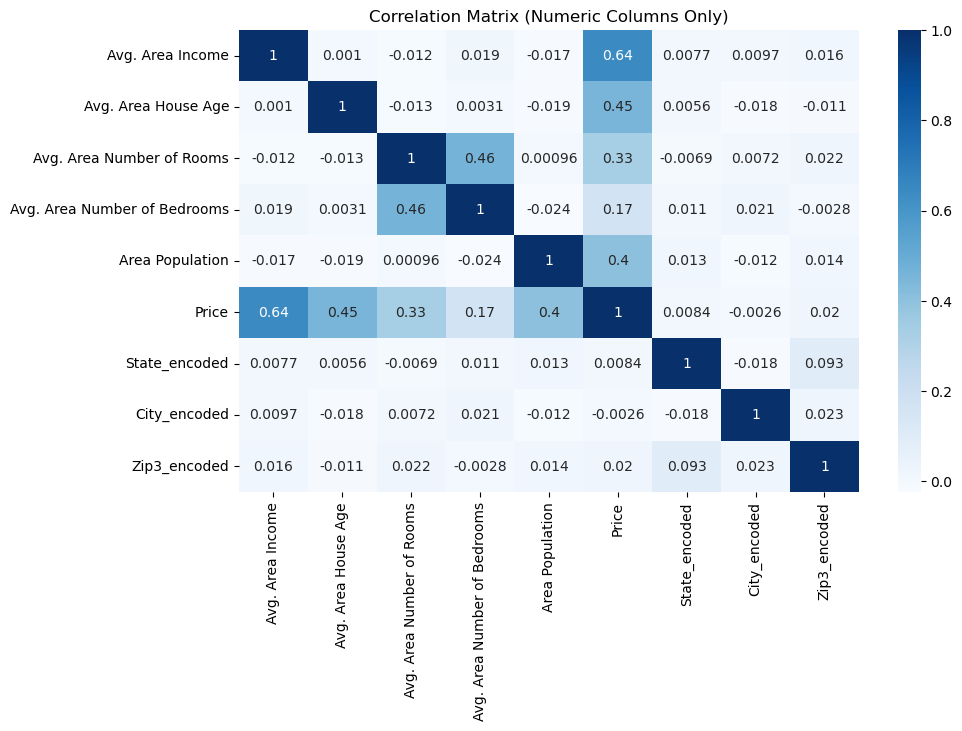


 Pearson Correlation with Price:
Price                           1.000000
Avg. Area Income                0.640103
Avg. Area House Age             0.454224
Area Population                 0.404195
Avg. Area Number of Rooms       0.333597
Avg. Area Number of Bedrooms    0.169230
Zip3_encoded                    0.020237
State_encoded                   0.008444
City_encoded                   -0.002623
Name: Price, dtype: float64

 Feature Importance (Random Forest):
                        Feature  Importance
0              Avg. Area Income    0.427686
1           Avg. Area House Age    0.228364
4               Area Population    0.180431
2     Avg. Area Number of Rooms    0.120283
3  Avg. Area Number of Bedrooms    0.011724
6                  City_encoded    0.011313
7                  Zip3_encoded    0.010398
5                 State_encoded    0.009801


/tmp/ipykernel_34512/376154865.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette="viridis")


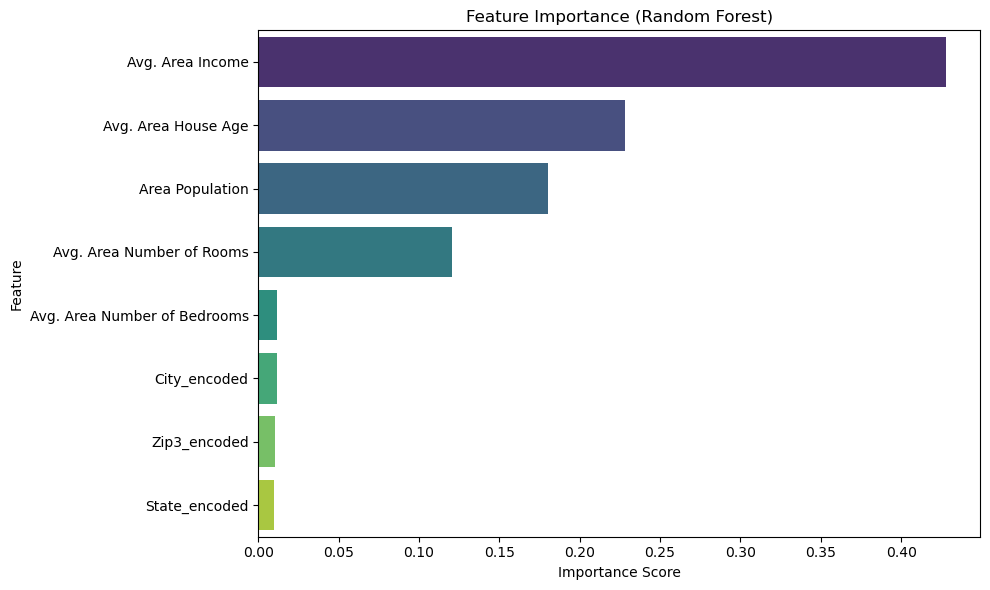

In [12]:

df_numeric = df.select_dtypes(include=['number'])  

correlation = df_numeric.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation, annot=True, cmap="Blues")
plt.title("Correlation Matrix (Numeric Columns Only)")
plt.show()

print("\n Pearson Correlation with Price:")
print(correlation['Price'].sort_values(ascending=False))


y = df['Price']

X = df.select_dtypes(include=['number']).drop(columns=['Price'])

model = RandomForestRegressor(random_state=42)
model.fit(X, y)

importances = model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\n Feature Importance (Random Forest):")
print(feature_importance_df)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette="viridis")
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


# Step Data Transformation

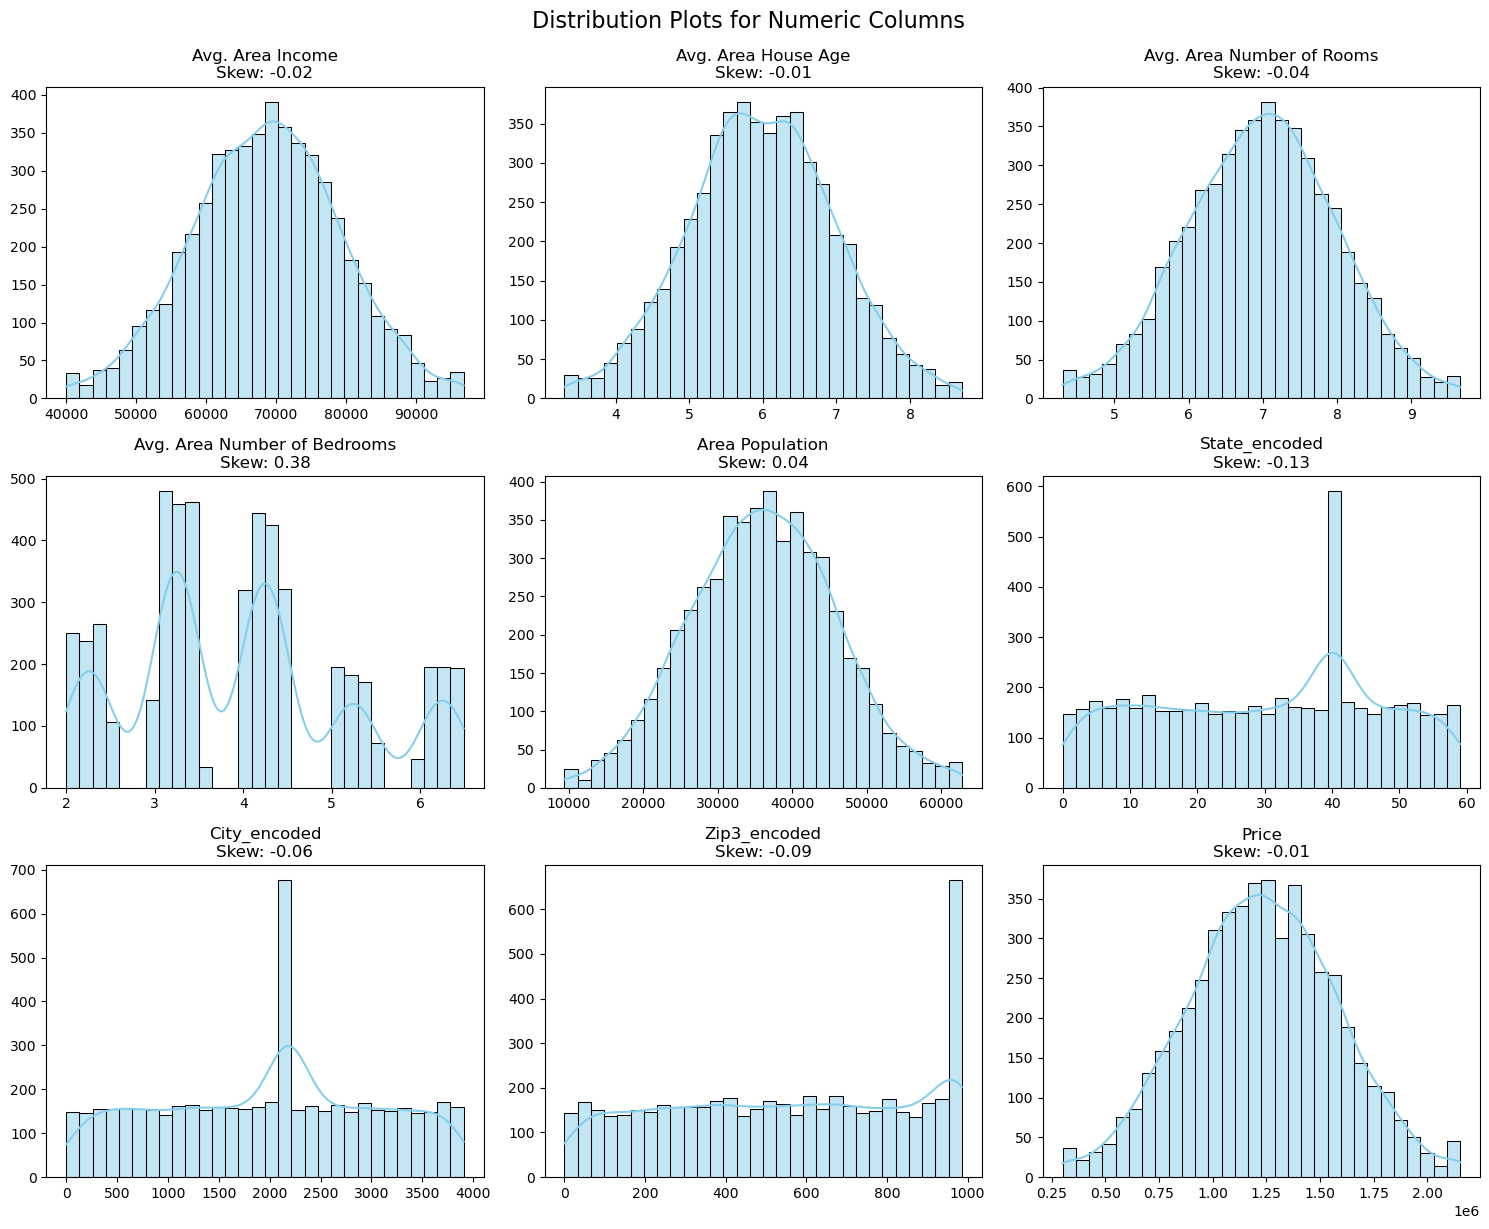

In [13]:

numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop('Price')

numeric_cols = list(numeric_cols) + ['Price']

cols_per_row = 3
total_cols = len(numeric_cols)
rows = int(np.ceil(total_cols / cols_per_row))

plt.figure(figsize=(cols_per_row * 5, rows * 4))

for i, col in enumerate(numeric_cols):
    plt.subplot(rows, cols_per_row, i + 1)
    sns.histplot(df[col], kde=True, bins=30, color='skyblue')
    plt.title(f"{col}\nSkew: {df[col].skew():.2f}")
    plt.xlabel('')
    plt.ylabel('')

plt.tight_layout()
plt.suptitle(" Distribution Plots for Numeric Columns", fontsize=16, y=1.02)
plt.show()


# 4.1) Split-out Validation Dataset
Split the dataset into training and validation sets.

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

X = df.select_dtypes(include=['number']).drop(columns=['Price'])
y = df['Price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)




# 4.2) Test Options and Evaluation Metric¶
Define the evaluation metric for the model.

In [15]:

model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(" Evaluation Metrics:")
print(f" Mean Squared Error (MSE): {mse:.2f}")
print(f" R-squared (R² Score): {r2:.4f}")


 Evaluation Metrics:
 Mean Squared Error (MSE): 13451732531.48
 R-squared (R² Score): 0.8894


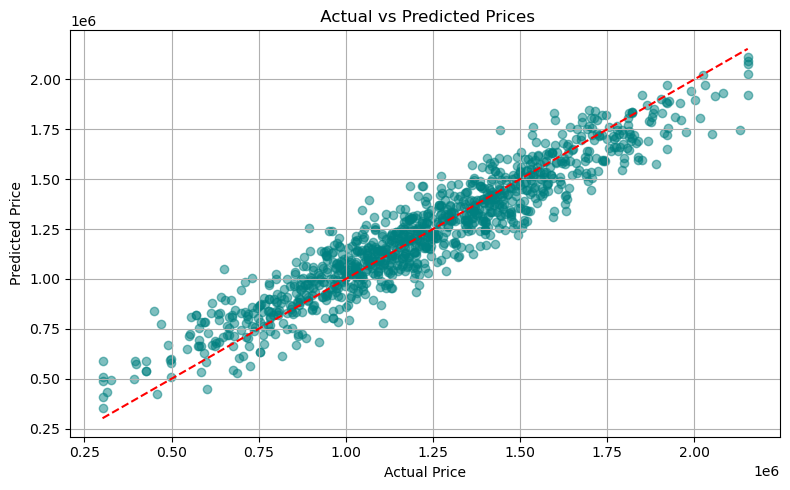

In [16]:

plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.5, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.title(" Actual vs Predicted Prices")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.grid(True)
plt.tight_layout()
plt.show()


# Feature Selection using DecisionTreeRegressor & Training the model with selected features


 Feature Importance (Decision Tree):
                        Feature  Importance
0              Avg. Area Income    0.418628
1           Avg. Area House Age    0.229910
4               Area Population    0.190500
2     Avg. Area Number of Rooms    0.122092
6                  City_encoded    0.010975
3  Avg. Area Number of Bedrooms    0.009880
5                 State_encoded    0.009045
7                  Zip3_encoded    0.008969


/tmp/ipykernel_4608/892878567.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette="YlGnBu")


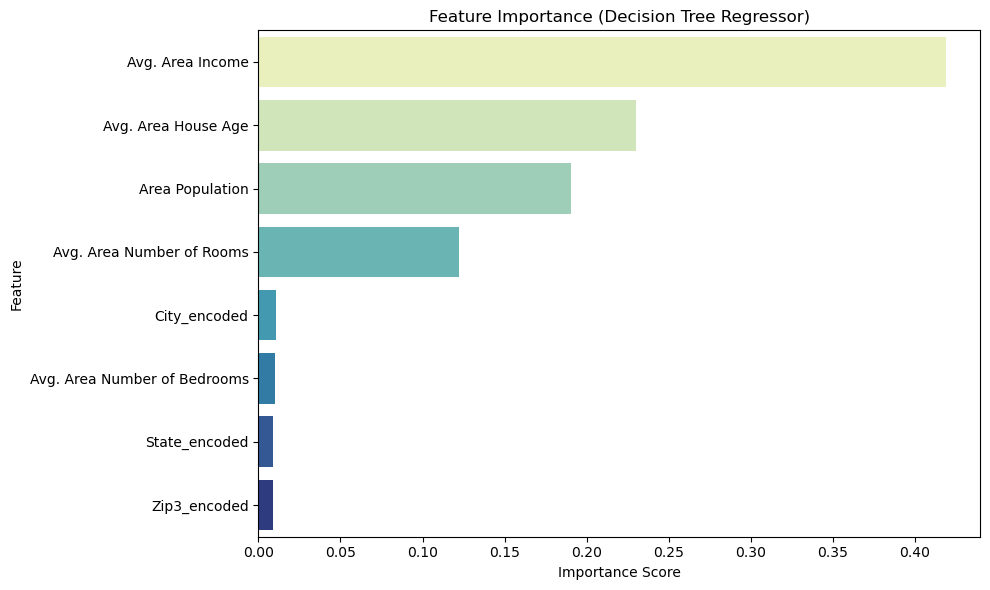


 Evaluation Metrics (Using Selected Features):
 Mean Squared Error (MSE): 28576573055.59
 R-squared (R² Score): 0.7650


In [14]:


X = df_numeric.drop(columns=['Price'])
y = df_numeric['Price']

#  Split the dataset into training and validation sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#  Decision Tree
model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)

#  Extract Feature Importance
importances = model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\n Feature Importance (Decision Tree):")
print(feature_importance_df)

#  What Is important feature ? for Decesion Tree model   
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette="YlGnBu")
plt.title("Feature Importance (Decision Tree Regressor)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

#   Feature Selection ( Importance > 0.01)
selected_features = feature_importance_df[feature_importance_df['Importance'] > 0.01]['Feature']
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

model_selected = DecisionTreeRegressor(random_state=42)
model_selected.fit(X_train_selected, y_train)
y_pred = model_selected.predict(X_test_selected)

# Evaluation Metrix
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n Evaluation Metrics (Using Selected Features):")
print(f" Mean Squared Error (MSE): {mse:.2f}")
print(f" R-squared (R² Score): {r2:.4f}")


# Feature Selection using RFE & Training Linear Regression model with selected features

Feature Selected From RFE:
Index(['Avg. Area Income', 'Avg. Area House Age', 'Avg. Area Number of Rooms',
       'Avg. Area Number of Bedrooms', 'Area Population'],
      dtype='object')

 Evaluation Matrix:
 Mean Squared Error (MSE): 9948245357.80
 R-squared (R²): 0.9182


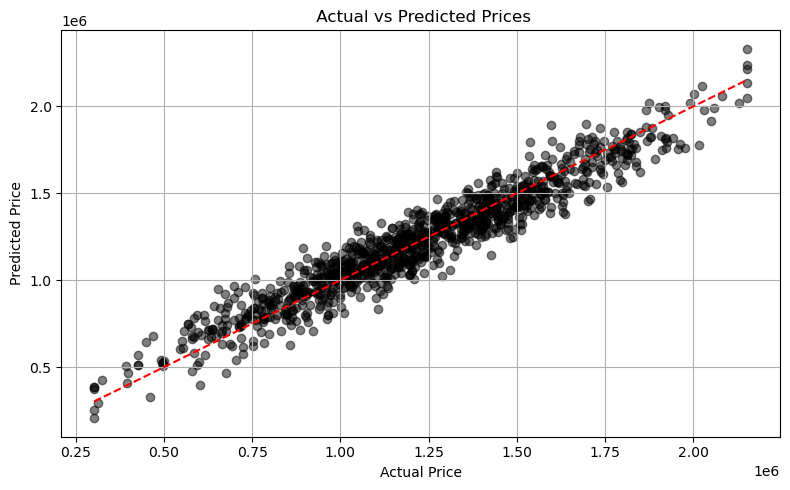

In [28]:


features = df.select_dtypes(include=['float64', 'int64']).drop(columns=['Price'])
target = df['Price']

#  Data Transformation ,Do scalling ( StandardScaler)
scaler = StandardScaler()
scaled_array = scaler.fit_transform(features)
df_scaled = pd.DataFrame(scaled_array, columns=features.columns)

# 
df_scaled['Price'] = target.values

# 
X = df_scaled.drop(columns=['Price'])
y = df_scaled['Price']

# 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#  LinearRegression
lr = LinearRegression()

# Do Feature Selection using RFE (Eg:take 5 feature)
rfe = RFE(estimator=lr, n_features_to_select=5)
rfe.fit(X_train, y_train)

selected_features = X.columns[rfe.support_]
print("Feature Selected From RFE:")
print(selected_features)

# Use the Selection Features Only
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Train The model with Seleced features only
model = LinearRegression()
model.fit(X_train_selected, y_train)

# Prediction
y_pred = model.predict(X_test_selected)
# Define Evaluation Matrix
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n Evaluation Matrix:")
print(f" Mean Squared Error (MSE): {mse:.2f}")
print(f" R-squared (R²): {r2:.4f}")

# Graph to compare the difference between Actual Vs. Prediction Values

plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.5, color='black')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.title(" Actual vs Predicted Prices")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.grid(True)
plt.tight_layout()
plt.show()


# Spot Check Algorithms¶
Test multiple algorithms to identify the best-performing one.

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{name} -> MSE: {mse:.2f}, R²: {r2:.4f}")


Linear Regression -> MSE: 9960825044.32, R²: 0.9181
Decision Tree -> MSE: 29792761677.16, R²: 0.7550
Random Forest -> MSE: 13468588682.48, R²: 0.8892


# Algorithm Tuning
Optimize hyperparameters for better performance.

# Optimize RandomForestRegressor with GridSearchCV

In [31]:


# Define the model
rf = RandomForestRegressor(random_state=42)

# Define the parameter grid
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

# GridSearchCV setup
grid_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf,
                       cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit to training data
grid_rf.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters for Random Forest:")
print(grid_rf.best_params_)

best_rf_model = grid_rf.best_estimator_

# Predict and evaluate
y_pred_rf = best_rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("\n Tuned Random Forest Metrics:")
print(f" MSE: {mse_rf:.2f}")
print(f" R² Score: {r2_rf:.4f}")


Best Parameters for Random Forest:
{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}

 Tuned Random Forest Metrics:
 MSE: 13398412178.82
 R² Score: 0.8898


# Optimize DecisionTreeRegressor

In [32]:
from sklearn.tree import DecisionTreeRegressor

# Define the model
dt = DecisionTreeRegressor(random_state=42)

# Define the parameter grid
param_grid_dt = {
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# GridSearchCV setup
grid_dt = GridSearchCV(estimator=dt, param_grid=param_grid_dt,
                       cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit to training data
grid_dt.fit(X_train, y_train)

# Best parameters and score
print("\n Best Parameters for Decision Tree:")
print(grid_dt.best_params_)

best_dt_model = grid_dt.best_estimator_

# Predict and evaluate
y_pred_dt = best_dt_model.predict(X_test)
mse_dt = mean_squared_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)

print("\n Tuned Decision Tree Metrics:")
print(f" MSE: {mse_dt:.2f}")
print(f" R² Score: {r2_dt:.4f}")



 Best Parameters for Decision Tree:
{'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}

 Tuned Decision Tree Metrics:
 MSE: 25203147804.51
 R² Score: 0.7927


# Ensembles¶
Combine multiple models to improve accuracy.


 Ensemble Voting Regressor Metrics:
 MSE: 12804953878.18
 R² Score: 0.8947


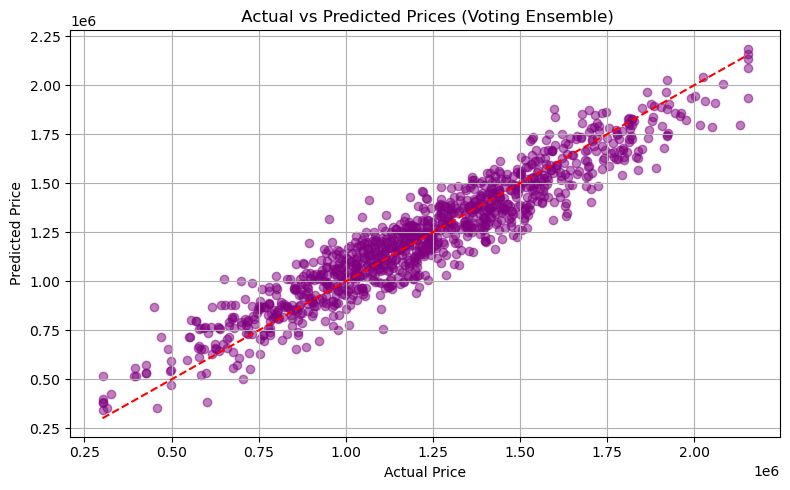

In [33]:
from sklearn.ensemble import VotingRegressor

X_train_common = X_train
X_test_common = X_test

# أعد تدريب LinearRegression باستخدام جميع الخصائص (نفس X_train)
model_lr_full = LinearRegression()
model_lr_full.fit(X_train_common, y_train)

# Voting Regressor
ensemble = VotingRegressor(estimators=[
    ('rf', best_rf_model),        # best tuned RF
    ('dt', best_dt_model),        # best tuned DT
    ('lr', model_lr_full)    # retrained LR with full features
])

# Fit and predict
ensemble.fit(X_train_common, y_train)
y_pred_ensemble = ensemble.predict(X_test_common)

# Evaluation
from sklearn.metrics import mean_squared_error, r2_score
mse_ensemble = mean_squared_error(y_test, y_pred_ensemble)
r2_ensemble = r2_score(y_test, y_pred_ensemble)

print("\n Ensemble Voting Regressor Metrics:")
print(f" MSE: {mse_ensemble:.2f}")
print(f" R² Score: {r2_ensemble:.4f}")

# Visualization
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred_ensemble, alpha=0.5, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.title(" Actual vs Predicted Prices (Voting Ensemble)")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.grid(True)
plt.tight_layout()
plt.show()



 Stacking Regressor Metrics:
 MSE: 9951633900.47
 R² Score: 0.9182


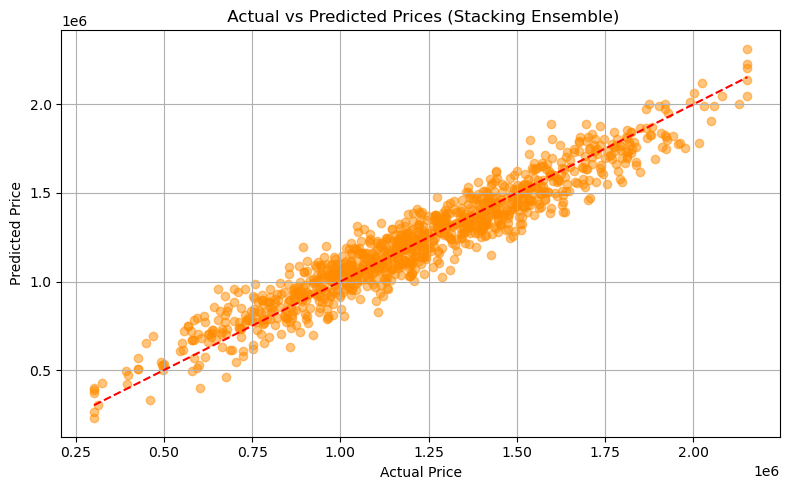

In [36]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X = df.select_dtypes(include=['number']).drop(columns=['Price'])
y = df['Price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Define base models
base_models = [
    ('dt', best_dt_model),     # Tuned Decision Tree
    ('rf', best_rf_model),     # Tuned Random Forest
    ('lr', LinearRegression()) # Linear Regression
]

# Define meta-model (usually simpler model like Linear Regression)
meta_model = LinearRegression()

# Build stacking model
stacking_model = StackingRegressor(
    estimators=base_models,
    final_estimator=meta_model,
    passthrough=False,  # If True, adds original features to meta-model
    cv=5,
    n_jobs=-1
)

# Train stacking model
stacking_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_stack = stacking_model.predict(X_test)

mse_stack = mean_squared_error(y_test, y_pred_stack)
r2_stack = r2_score(y_test, y_pred_stack)

print("\n Stacking Regressor Metrics:")
print(f" MSE: {mse_stack:.2f}")
print(f" R² Score: {r2_stack:.4f}")

# Visualization
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred_stack, alpha=0.5, color='darkorange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.title(" Actual vs Predicted Prices (Stacking Ensemble)")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.grid(True)
plt.tight_layout()
plt.show()


In [34]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

bagging_model = BaggingRegressor(
    estimator=DecisionTreeRegressor(random_state=42),
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

# 
bagging_model.fit(X_train, y_train)

#  
y_pred_bagging = bagging_model.predict(X_test)
mse_bagging = mean_squared_error(y_test, y_pred_bagging)
r2_bagging = r2_score(y_test, y_pred_bagging)

print("\n Bagging Regressor Metrics:")
print(f" MSE: {mse_bagging:.2f}")
print(f" R² Score: {r2_bagging:.4f}")



 Bagging Regressor Metrics:
 MSE: 13552413429.68
 R² Score: 0.8885


In [37]:
from sklearn.ensemble import GradientBoostingRegressor

gbr_model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

gbr_model.fit(X_train, y_train)

y_pred_gbr = gbr_model.predict(X_test)
mse_gbr = mean_squared_error(y_test, y_pred_gbr)
r2_gbr = r2_score(y_test, y_pred_gbr)

print("\n Gradient Boosting Regressor Metrics:")
print(f" MSE: {mse_gbr:.2f}")
print(f" R² Score: {r2_gbr:.4f}")



 Gradient Boosting Regressor Metrics:
 MSE: 11231507142.14
 R² Score: 0.9076


# Do Comparasion Which one is give better perferomance 

In [38]:
results = {
    'Linear Regression': {'MSE': 9948245357.80, 'R2': 0.9182},
    'Decision Tree':     {'MSE': 25203147804.51, 'R2': 0.7927},
    'Random Forest':     {'MSE': 13398412178.82, 'R2': 0.8898},
    'Voting Regressor':  {'MSE': 12804953878.18, 'R2': 0.8947},
    'Stacking Regressor':{'MSE': 9951633900.47, 'R2': 0.9182},
    'Bagging Regressor': {'MSE': 13559620568.75, 'R2': 0.8885},
    'Gradient Boosting': {'MSE': 11231507142.14, 'R2': 0.9076},
}


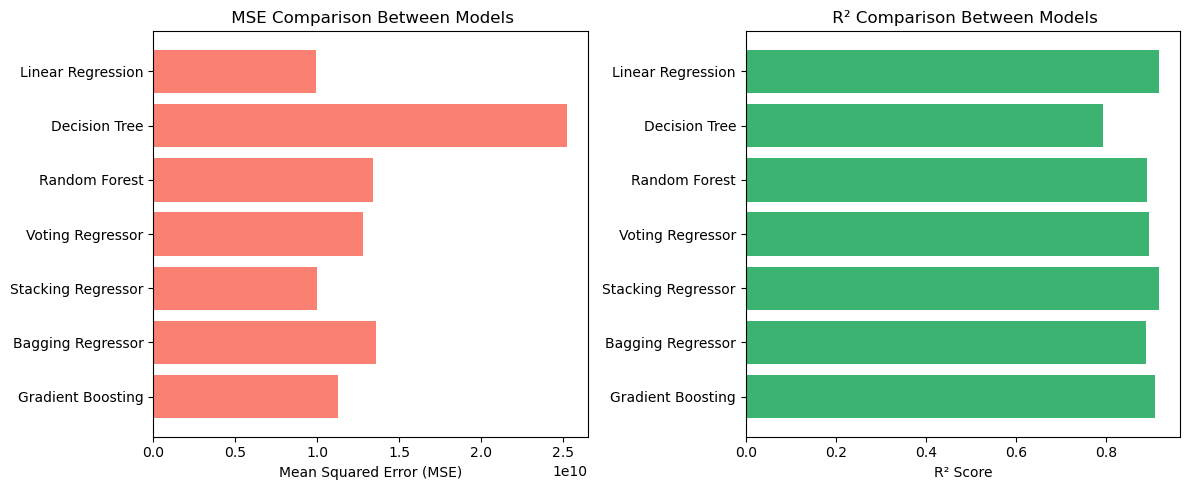

In [39]:
import matplotlib.pyplot as plt

models = list(results.keys())
mse_scores = [results[model]['MSE'] for model in models]
r2_scores = [results[model]['R2'] for model in models]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.barh(models, mse_scores, color='salmon')
plt.xlabel("Mean Squared Error (MSE)")
plt.title(" MSE Comparison Between Models")
plt.gca().invert_yaxis()

plt.subplot(1, 2, 2)
plt.barh(models, r2_scores, color='mediumseagreen')
plt.xlabel("R² Score")
plt.title(" R² Comparison Between Models")
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()
